In [1]:
import os
import sys

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

DESCARTES_DIR = '/ihme/code/rmbarber/DL-COVID-19'


## read in Descartes data

In [2]:
df = pd.read_csv(f'{DESCARTES_DIR}/DL-us-mobility-daterow.csv')
df = df.loc[(df['country_code'] == 'US') & (df['admin_level'] == 1)]
df['date'] = pd.to_datetime(df['date'])
df = df.rename(index=str, columns={'admin1':'Location'})
df = df[['Location', 'date', 'm50_index']]

# cap index at 100 (based on mobility relative to a window from 02/17-03/07)
df.loc[df['m50_index'] > 100, 'm50_index'] = 100
df['m50_index'] = df['m50_index'] / 100


## compare IHME covariate to mobility data

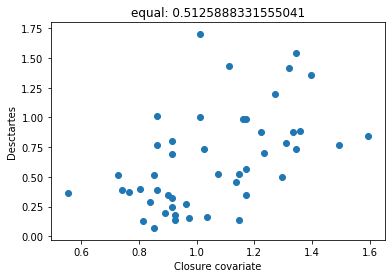

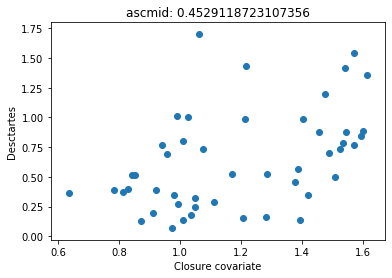

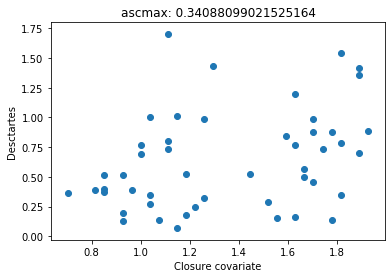

In [12]:
for scheme in ['equal', 'ascmid', 'ascmax']:
    cov_df = pd.read_csv(f'/ihme/covid-19/deaths/prod/2020_04_08_US/model_data_{scheme}_21/New York covariate.csv')
    cov_df = cov_df.loc[cov_df['Country/Region'] == 'United States of America', 
                        ['Location', 'cov_1w', 'threshold_date']]
    cov_df['threshold_date'] = pd.to_datetime(cov_df['threshold_date'])

    plot_df = df.merge(cov_df[['Location', 'threshold_date']])
    plot_df = plot_df.loc[plot_df['date'] >= plot_df['threshold_date']]
    plot_df = plot_df.groupby(['Location'], as_index=False)['m50_index'].sum()

    plot_df = plot_df.merge(cov_df[['Location', 'cov_1w']])

    plt.scatter(plot_df['cov_1w'], plot_df['m50_index'] / 6)
    plt.xlabel(f'Closure covariate')
    plt.ylabel('Desctartes')
    plt.title(f"{scheme}: {np.corrcoef(plot_df['cov_1w'], plot_df['m50_index'])[0,1]}")
    plt.show()


## keep after threshold and add up days

0.4529118723107356

array([232.6568254])